In [580]:
import pandas as pd

# df=pd.read_csv("df_final_2.csv")
X_train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]
y_train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]
X_test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]
y_test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

# X_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]
# y_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]
# X_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]
# y_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

In [581]:
train_series_data_stats = pd.read_csv('train_series_data_stats.csv')
test_series_data_stats = pd.read_csv('test_series_data_stats.csv')

# train_series_data_stats = pd.read_csv('/kaggle/input/series-data-v2/train_series_data_stats.csv')
# test_series_data_stats = pd.read_csv('/kaggle/input/series-data-v2/test_series_data_stats.csv')

In [582]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

def get_aggregations(df, column_groupby, column_agg):

    if not isinstance(column_agg, list):
        column_agg = [column_agg]
    
    # Create the aggregation dictionary
    aggregation_dict = {}
    for col in column_agg:
        aggregation_dict.update({
            f'Median_{col}': (col, 'median'),
            f'Max_{col}': (col, 'max'),
            f'Min_{col}': (col, 'min'),
            f'Sum_{col}': (col, 'sum'),
            f'Std_{col}': (col, 'std'),
            f'Mean_{col}': (col, 'mean')
        })
    
    # Perform groupby and aggregation
    df_agg = df.groupby(column_groupby).agg(**aggregation_dict).reset_index()

    return df_agg


In [583]:
def fill_na(df, column_groupby, column):

    group_mean = df.groupby(column_groupby)[column].transform('mean')
    overall_mean = df[column].mean()
    df[column] = df[column].fillna(group_mean).fillna(overall_mean)
    # df[f'{column}_{"New"}'] = df[column].fillna(group_mean).fillna(overall_mean)

    return df

In [584]:
merged_data = X_train.merge(train_series_data_stats, how='left', on='id')

In [585]:
merged_data_df = merged_data.select_dtypes(include='number')
correlation_matrix = merged_data_df.corr()

In [586]:
# correlation_matrix.to_excel('corr_matrix.xlsx')

In [587]:
stat_columns = [col for col in merged_data_df.columns if col.startswith("stat")]

In [588]:
X_train = merged_data

In [589]:
df = fill_na(X_train, 'PCIAT-PCIAT_Total', 'FGC-FGC_CU')
df = fill_na(X_train, 'PCIAT-PCIAT_Total', 'Physical-Systolic_BP')
df = fill_na(X_train, 'PCIAT-PCIAT_Total', 'Physical-BMI')
df = fill_na(X_train, 'PCIAT-PCIAT_Total', 'BIA-BIA_BMC')
df = fill_na(X_train, 'PCIAT-PCIAT_Total', 'BIA-BIA_BMI')
df = fill_na(pd.concat([X_train, y_train], axis=1), 'sii', 'PCIAT-PCIAT_Total')

In [590]:
other_columns = stat_columns
column_groupby = 'PCIAT-PCIAT_Total'
column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-BMI','BIA-BIA_BMC','BIA-BIA_BMI','Basic_Demos-Sex']
# column_agg=['Basic_Demos-Sex','BIA-BIA_BMC']
# column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-Diastolic_BP','Physical-BMI'] # 0.152

df_agg = get_aggregations(df, column_groupby=column_groupby, column_agg=column_agg)

for column in df_agg.columns:
    df_agg[column] = df_agg[column].fillna(df_agg[column].mean())

In [591]:
# from sklearn.preprocessing import PolynomialFeatures
# import pandas as pd

# # Initialize PolynomialFeatures with specified degree
# poly = PolynomialFeatures(degree=3, include_bias=False)

# columns=['FGC-FGC_CU','Physical-Systolic_BP','Physical-BMI','BIA-BIA_BMC','BIA-BIA_BMI']
# columns_new = [col + "_New" for col in columns]

# # Select columns and generate polynomial features
# poly_features = df[columns_new]
# poly_array = poly.fit_transform(poly_features)
# poly_df = pd.DataFrame(poly_array, columns=poly.get_feature_names_out(columns_new))


In [592]:
print(f'Features with highest correlation to {column_groupby} \n')
columns_corr=[]
for column in column_agg:

    corr_df = df_agg.loc[:, df_agg.columns[df_agg.columns.str.endswith(column)].tolist()]
    corr_df[column_groupby] = df_agg[column_groupby]
    correlation_matrix = corr_df.corr()
    feature_highest_corr = correlation_matrix[column_groupby].drop(column_groupby).abs().idxmax()
    feature_corr_value = correlation_matrix[column_groupby].drop(column_groupby).abs().max()
    print(f'{feature_highest_corr}: {feature_corr_value} \n')

    columns_corr.append(feature_highest_corr)

print(columns_corr)

Features with highest correlation to PCIAT-PCIAT_Total 

Min_FGC-FGC_CU: 0.6346970261059559 

Min_Physical-Systolic_BP: 0.5868623112249651 

Median_Physical-BMI: 0.646820881538091 

Min_BIA-BIA_BMC: 0.5264354125489384 

Min_BIA-BIA_BMI: 0.6816141947983803 

Max_Basic_Demos-Sex: 0.468028972462439 

['Min_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Median_Physical-BMI', 'Min_BIA-BIA_BMC', 'Min_BIA-BIA_BMI', 'Max_Basic_Demos-Sex']


In [593]:
columns_corr = [item for item in columns_corr if item is not None and not (isinstance(item, float) and np.isnan(item))]

In [594]:
# all_columns = other_columns + [column_groupby] + columns_corr
all_columns = [column_groupby] + columns_corr + other_columns

In [595]:
columns_df_agg = [column_groupby] + columns_corr
df_agg = df_agg.loc[:, columns_df_agg]

In [596]:
df_agg.describe()

,PCIAT-PCIAT_Total,Min_FGC-FGC_CU,Min_Physical-Systolic_BP,Median_Physical-BMI,Min_BIA-BIA_BMC,Min_BIA-BIA_BMI,Max_Basic_Demos-Sex
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,45.881874,3.409781,93.755319,20.056653,1.502083,15.610619,0.904255
std,27.031928,6.900725,19.137132,3.899655,3.002747,4.618211,0.295818
min,0.000000,0.000000,0.000000,15.515430,-7.789610,0.048267,0.000000
25%,23.250000,0.000000,87.000000,17.880742,-0.057405,13.474475,1.000000
50%,45.500000,0.000000,93.000000,19.177754,1.822565,14.221050,1.000000
75%,68.750000,3.000000,101.000000,20.495010,2.923608,16.300300,1.000000
max,93.000000,28.000000,166.000000,39.339185,8.168670,39.343500,1.000000


In [597]:
# columns = [column_groupby]
# columns = columns + columns_corr + other_columns
# print(columns)
new_X_train = X_train.merge(df_agg, how='left', on=column_groupby)[all_columns]

In [598]:
for column in df_agg.columns:
    new_X_train[column] = new_X_train[column].fillna(df_agg[column].mean())

In [599]:
for column in other_columns:
    new_X_train[column] = new_X_train[column].fillna(new_X_train[column].mean())

In [600]:
new_X_train.isna().sum()
len(new_X_train)

3960

In [601]:
new_df_train = new_X_train.select_dtypes(include='number')
correlation_matrix = new_df_train.corr()

In [602]:
correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

,PCIAT-PCIAT_Total,Min_FGC-FGC_CU,Min_Physical-Systolic_BP,Median_Physical-BMI,Min_BIA-BIA_BMC,Min_BIA-BIA_BMI,Max_Basic_Demos-Sex,stat_0,stat_1,stat_2,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
PCIAT-PCIAT_Total,1.000000,0.567088,0.592919,0.760885,NaN,0.593088,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min_FGC-FGC_CU,0.567088,1.000000,NaN,0.600485,NaN,0.638476,-0.686285,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min_Physical-Systolic_BP,0.592919,NaN,1.000000,0.527087,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Median_Physical-BMI,0.760885,0.600485,0.527087,1.000000,NaN,0.619717,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min_BIA-BIA_BMC,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stat_91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
stat_92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
stat_93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
stat_94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [603]:
# correlation_matrix.to_excel('corr_matrix_05.xlsx')

In [604]:
from sklearn.model_selection import train_test_split

df = pd.concat([new_X_train, y_train], axis=1)
df = df[df['sii'].notna()]
X = df.iloc[:, :-1]
y = df['sii']
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)


In [605]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_split, y_train_split)
test_score = reg.score(X_test_split, y_test_split)
print(f'Test Score: {test_score}')

Test Score: 0.8174420052972409


In [606]:
null_indexes = y_train[y_train.isna()].index

In [607]:
X_null = new_X_train.iloc[null_indexes] 

In [608]:
y_pred = reg.predict(X_null) 

(array([   0.,    0.,    0.,    0.,    0., 1224.,    0.,    0.,    0.,
           0.]),
 array([0.71919516, 0.81919516, 0.91919516, 1.01919516, 1.11919516,
        1.21919516, 1.31919516, 1.41919516, 1.51919516, 1.61919516,
        1.71919516]),
 <BarContainer object of 10 artists>)

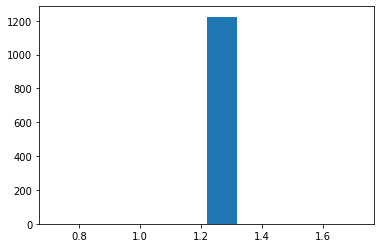

In [609]:
import matplotlib.pyplot as plt
plt.hist(y_pred)

In [610]:
y_train.iloc[null_indexes] = y_pred

In [611]:
y_train = np.round(y_train)

In [612]:
X_train = new_X_train.drop(columns=column_groupby)

In [613]:
# evaluate_linear_models(X_train, y_train)

In [614]:
local_X_train, local_X_test, local_y_train, local_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [615]:
# from sklearn.preprocessing import StandardScaler

# # Assume 'feature_to_scale' is the name of the feature you want to scale
# feature_to_scale = 'Max_stat_72'

# # Create an instance of StandardScaler
# scaler = StandardScaler()

# # Fit and transform only the selected feature
# local_X_train[[feature_to_scale]] = scaler.fit_transform(local_X_train[[feature_to_scale]])
# local_X_test[[feature_to_scale]] = scaler.transform(local_X_test[[feature_to_scale]])

In [616]:
# from sklearn.preprocessing import MinMaxScaler

# feature_to_scale = 'Mean_Basic_Demos-Age'

# # Initialize MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))

# # Fit and transform on the training set, and transform on the test set
# local_X_train[[feature_to_scale]] = scaler.fit_transform(local_X_train[[feature_to_scale]])
# local_X_test[[feature_to_scale]] = scaler.transform(local_X_test[[feature_to_scale]])

In [617]:
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# # Initialize the model
# model = LGBMRegressor()

# # Parameter grid for tuning
# param_grid = {
#     'num_leaves': [20, 31, 40, 50],
#     'max_depth': [-1, 5, 10, 15],
#     'learning_rate': [0.1, 0.05, 0.01],
#     'n_estimators': [100, 200, 500],
#     'min_child_samples': [10, 20, 30],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

In [618]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=50,  # Number of parameter combinations to try
#     scoring='neg_mean_squared_error',  # Customize based on your task
#     cv=5,  # Number of folds for cross-validation
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the randomized search
# random_search.fit(local_X_train, local_y_train)

# # Best parameters and score
# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)

In [619]:
# from sklearn.metrics import mean_squared_error, r2_score

# # Train the final model with the best parameters
# best_params = random_search.best_params_  # or grid_search.best_params_
# final_model = LGBMRegressor(**best_params)
# final_model.fit(local_X_train, local_y_train)

# # Predict and evaluate on the test set
# local_y_pred = final_model.predict(local_X_test)
# mse = mean_squared_error(local_y_test, local_y_pred)
# r2 = r2_score(local_y_test, local_y_pred)
# print("Mean Squared Error on Test Set:", mse)
# print("R² Score on Test Set:", r2)

In [620]:
final_model = LinearRegression()
final_model.fit(local_X_train, local_y_train)

LinearRegression()

In [621]:
final_model.score(local_X_test, local_y_test)

0.5464877730251877

In [622]:
local_y_pred = final_model.predict(local_X_test)
local_y_train_pred = final_model.predict(local_X_train)

# conditions = [local_y_pred <= 0, local_y_pred <= 1, local_y_pred <= 2, local_y_pred <= 3]
# choices = [0, 1, 2, 3]
# local_y_pred = np.select(conditions, choices, default=1)

local_y_pred = np.round(local_y_pred).astype(int)
local_y_train_pred = np.round(local_y_train_pred).astype(int)

In [623]:
from sklearn.ensemble import RandomForestClassifier
final_model = RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 1, 3: 3})  # Give higher weight to class 3
final_model.fit(local_X_train, local_y_train)

final_model.score(local_X_test, local_y_test)
local_y_pred = final_model.predict(local_X_test)
local_y_train_pred = final_model.predict(local_X_train)
local_y_pred = np.round(local_y_pred).astype(int)
local_y_train_pred = np.round(local_y_train_pred).astype(int)

In [624]:
# import xgboost as xgb
# final_model = xgb.XGBClassifier(scale_pos_weight=10)  # Adjust 'scale_pos_weight' for class '3'
# final_model.fit(local_X_train, local_y_train)

# final_model.score(local_X_test, local_y_test)
# local_y_pred = final_model.predict(local_X_test)
# local_y_train_pred = final_model.predict(local_X_train)
# local_y_pred = np.round(local_y_pred).astype(int)
# local_y_train_pred = np.round(local_y_train_pred).astype(int)

In [625]:
# import xgboost as xgb
# final_model = xgb.XGBClassifier(
#     learning_rate=0.05,
#     n_estimators=150,
#     subsample=0.8,  # Randomly sample 80% of training data
#     colsample_bytree=0.8,  # Randomly sample 80% of features
#     max_depth=6,  # Limiting the depth of trees
#     reg_alpha=1,  # L1 regularization
#     reg_lambda=1  # L2 regularization
# )
# final_model.fit(local_X_train, local_y_train)

# final_model.score(local_X_test, local_y_test)
# local_y_pred = final_model.predict(local_X_test)
# local_y_train_pred = final_model.predict(local_X_train)
# local_y_pred = np.round(local_y_pred).astype(int)
# local_y_train_pred = np.round(local_y_train_pred).astype(int)

In [626]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [10, 12, 15],
#     'num_leaves': [31, 50, 100],
#     'min_data_in_leaf': [10, 13, 20],
#     'feature_fraction': [0.8, 0.9, 1.0],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'bagging_freq': [2, 4, 5],
#     'lambda_l1': [1, 5, 10],
#     'lambda_l2': [0.01, 0.1, 1]
# }

# grid_search = GridSearchCV(estimator=final_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)

In [649]:
import lightgbm as lgb
final_model = lgb.LGBMRegressor(**{
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 150,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
})

final_model.fit(local_X_train, local_y_train)

final_model.score(local_X_test, local_y_test)
local_y_pred = final_model.predict(local_X_test)
local_y_train_pred = final_model.predict(local_X_train)
local_y_pred = np.round(local_y_pred).astype(int)
local_y_train_pred = np.round(local_y_train_pred).astype(int)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be 

In [650]:
from sklearn.model_selection import cross_val_score

cross_val_score(final_model, local_X_train, local_y_train, cv=5).mean()

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be 

np.float64(0.9474074039087848)

In [651]:
from sklearn.metrics import cohen_kappa_score

qwk_score_train = cohen_kappa_score(local_y_train, local_y_train_pred, weights='quadratic')
qwk_score_val = cohen_kappa_score(local_y_test, local_y_pred, weights='quadratic')
print("Train QWK Score:", qwk_score_train)
print("Validation QWK Score:", qwk_score_val)


Train QWK Score: 0.9799664655646693
Validation QWK Score: 0.9685757039858522


In [630]:
results = pd.concat([local_y_test.reset_index(), pd.DataFrame(local_y_pred)], axis=1)
results.to_excel('results_local_test_data.xlsx')

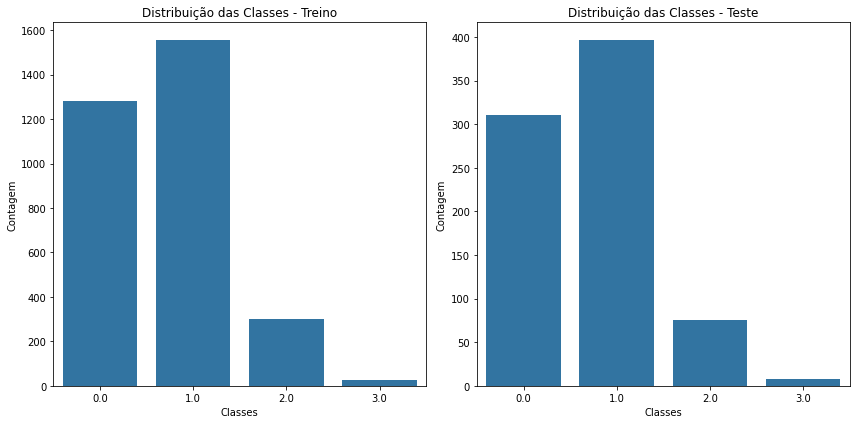

In [631]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponha que você tenha um DataFrame `train` e `test`, e a coluna `target` contém a variável alvo
plt.figure(figsize=(12, 6))

# Treino
plt.subplot(1, 2, 1)
sns.countplot(x='sii', data=pd.DataFrame(local_y_train))
plt.title('Distribuição das Classes - Treino')
plt.xlabel('Classes')
plt.ylabel('Contagem')

# Teste
plt.subplot(1, 2, 2)
sns.countplot(x='sii', data=pd.DataFrame(local_y_test))
plt.title('Distribuição das Classes - Teste')
plt.xlabel('Classes')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

In [632]:
# for column in columns_corr:
#     plt.figure(figsize=(12, 6))

#     # Treino
#     sns.kdeplot(local_X_train[column], label='Treino', color='blue')
#     sns.kdeplot(local_X_test[column], label='Teste', color='red')
#     plt.title(f'Distribuição {column} - Treino vs Teste')
#     plt.xlabel('Valores da Feature')
#     plt.ylabel('Densidade')
#     plt.legend()
#     plt.show()

In [633]:
all_columns

['PCIAT-PCIAT_Total',
 'Min_FGC-FGC_CU',
 'Min_Physical-Systolic_BP',
 'Median_Physical-BMI',
 'Min_BIA-BIA_BMC',
 'Min_BIA-BIA_BMI',
 'Max_Basic_Demos-Sex',
 'stat_0',
 'stat_1',
 'stat_2',
 'stat_3',
 'stat_4',
 'stat_5',
 'stat_6',
 'stat_7',
 'stat_8',
 'stat_9',
 'stat_10',
 'stat_11',
 'stat_12',
 'stat_13',
 'stat_14',
 'stat_15',
 'stat_16',
 'stat_17',
 'stat_18',
 'stat_19',
 'stat_20',
 'stat_21',
 'stat_22',
 'stat_23',
 'stat_24',
 'stat_25',
 'stat_26',
 'stat_27',
 'stat_28',
 'stat_29',
 'stat_30',
 'stat_31',
 'stat_32',
 'stat_33',
 'stat_34',
 'stat_35',
 'stat_36',
 'stat_37',
 'stat_38',
 'stat_39',
 'stat_40',
 'stat_41',
 'stat_42',
 'stat_43',
 'stat_44',
 'stat_45',
 'stat_46',
 'stat_47',
 'stat_48',
 'stat_49',
 'stat_50',
 'stat_51',
 'stat_52',
 'stat_53',
 'stat_54',
 'stat_55',
 'stat_56',
 'stat_57',
 'stat_58',
 'stat_59',
 'stat_60',
 'stat_61',
 'stat_62',
 'stat_63',
 'stat_64',
 'stat_65',
 'stat_66',
 'stat_67',
 'stat_68',
 'stat_69',
 'stat_70',


In [634]:
column_agg
# print(columns_agg_after)

['FGC-FGC_CU',
 'Physical-Systolic_BP',
 'Physical-BMI',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'Basic_Demos-Sex']

In [635]:
merged_data_X_test = X_test.merge(test_series_data_stats, how='left', on='id')

In [636]:
for column in other_columns:
    merged_data_X_test[column] = merged_data_X_test[column].fillna(new_X_train[column].mean())

In [637]:
X_test_predict = merged_data_X_test.loc[:, column_agg + other_columns]

In [638]:
for column in column_agg:
    index = column_agg.index(column)
    if X_test_predict[column].isna().sum() > 0:
        try:
            X_test_predict[columns_corr[index]] = X_test_predict[column].fillna(df_agg[columns_corr[index]].mean())
        except:
            print(index)
    else:
        X_test_predict[columns_corr[index]] = X_test_predict[column]

<ipython-input-638-4db0297c3fc1>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_predict[columns_corr[index]] = X_test_predict[column].fillna(df_agg[columns_corr[index]].mean())
<ipython-input-638-4db0297c3fc1>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_predict[columns_corr[index]] = X_test_predict[column].fillna(df_agg[columns_corr[index]].mean())
<ipython-input-638-4db0297c3fc1>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [639]:
X_test_predict = X_test_predict.loc[:, columns_corr + other_columns]

In [640]:
y_test = final_model.predict(X_test_predict)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=0.784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [641]:
y_test

array([1.37503572, 0.3678674 , 1.51616121, 2.04539852, 0.99413267,
       2.37452392, 2.0577014 , 1.79846387, 0.99413267, 0.99413267,
       0.99413267, 0.99413267, 2.35805826, 1.52523812, 0.99413267,
       2.11392724, 1.5725672 , 0.75204031, 2.21000393, 0.99413267])

In [642]:
y_test_round = np.round(y_test).astype(int)

In [643]:
# y_test_round = round_final_results(y_test_round)

In [644]:
print(y_test_round)

[1 0 2 2 1 2 2 2 1 1 1 1 2 2 1 2 2 1 2 1]


In [645]:
df_y_test = pd.DataFrame({'id': X_test['id'], 'sii': y_test_round})

In [646]:
from datetime import datetime
df_y_test.to_csv(f'submission.csv', index=False)

In [647]:
df_y_test

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,2
3,00115b9f,2
4,0016bb22,1
5,001f3379,2
6,0038ba98,2
7,0068a485,2
8,0069fbed,1
9,0083e397,1


In [648]:
# pd.concat([X_train,y_train], axis=1).to_csv('df_final_to_powerbi_2.csv')